[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/machinelearnear/video-super-resolution-youtube/blob/main/example_w_RealBasicVSR.ipynb)

# Real-World Video Super-Resolution & YouTube

- RealBasicVSR Paper: ["Investigating Tradeoffs in Real-World Video Super-Resolution"](https://arxiv.org/pdf/2111.12704.pdf)
- RealBasicVSR Repo: https://github.com/ckkelvinchan/RealBasicVSR
- Open-source VSR tool (Windows): https://github.com/AaronFeng753/Waifu2x-Extension-GUI

## Notebook setup

In [1]:
# check gpu status
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f1a5ee90-3129-099c-e899-7eab67776abd)


In [2]:
try:
    import mmcv
    import mmedit
except:
    !pip install openmim
    !mim install mmcv-full
    !pip install mmedit

In [ ]:
try:
    import cv2
except:
    !conda install opencv

In [3]:
import time
import glob
import os
import sys
import cv2
import mmcv
import numpy as np
import torch
import shutil
import multiprocessing as mp
import matplotlib.pyplot as plt

Clone `RealBasicVSR` and download the pre-trained weights

In [4]:
PathToRepo = 'RealBasicVSR'
ConfigFile = f'{PathToRepo}/configs/realbasicvsr_x4.py'
ModelWeights = f'{PathToRepo}/checkpoints/RealBasicVSR_x4.pth'

In [5]:
from os.path import exists as path_exists
if not path_exists(ModelWeights):
    !git clone https://github.com/ckkelvinchan/RealBasicVSR.git
    !curl https://www.dropbox.com/s/eufigxmmkv5woop/RealBasicVSR.pth?dl=0 --create-dirs -o $ModelWeights

In [6]:
sys.path.append(PathToRepo)
from realbasicvsr.models.builder import build_model
from mmcv.runner import load_checkpoint
from mmedit.core import tensor2img
from pathlib import Path
from generate_video_demo import VideoDemo
from PIL import Image
from functools import partial
from tqdm import tqdm

In [7]:
base_dir = Path('data')
source_dir = base_dir/'inputs'
target_dir = base_dir/'results'
tmp_dir = base_dir/'tmp'

In [8]:
source_dir.mkdir(parents=True,exist_ok=True)
target_dir.mkdir(parents=True,exist_ok=True)

## Test model with your own video

### Load the pre-trained model

In [9]:
def init_model(config, checkpoint=None):
    """Initialize a model from config file.
    Args:
        config (str or :obj:`mmcv.Config`): Config file path or the config
            object.
        checkpoint (str, optional): Checkpoint path. If left as None, the model
            will not load any weights.
        device (str): Which device the model will deploy. Default: 'cuda:0'.
    Returns:
        nn.Module: The constructed model.
    """

    if isinstance(config, str):
        config = mmcv.Config.fromfile(config)
    elif not isinstance(config, mmcv.Config):
        raise TypeError('config must be a filename or Config object, '
                        f'but got {type(config)}')
    config.model.pretrained = None
    config.test_cfg.metrics = None
    model = build_model(config.model, test_cfg=config.test_cfg)
    if checkpoint is not None:
        checkpoint = load_checkpoint(model, checkpoint)

    model.cfg = config  # save the config in the model for convenience
    model.eval()

    return model

In [10]:
model = init_model(ConfigFile, ModelWeights)

2022-03-06 12:20:29,682 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/studio-lab-user/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

load checkpoint from local path: RealBasicVSR/checkpoints/RealBasicVSR_x4.pth


In [11]:
cuda_flag = False
if torch.cuda.is_available():
    model = model.cuda()
    cuda_flag = True

### Download video from YouTube

Source: https://github.com/ytdl-org/youtube-dl

```sh
# Download best mp4 format available or any other best if no mp4 available
!youtube-dl -f 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best'

# Download best format available but no better than 480p
!youtube-dl -f 'bestvideo[height<=480]+bestaudio/best[height<=480]'

# Download best video only format but no bigger than 50 MB
!youtube-dl -f 'best[filesize<50M]'

# Download best format available via direct link over HTTP/HTTPS protocol
!youtube-dl -f '(bestvideo+bestaudio/best)[protocol^=http]'

# Download the best video format and the best audio format without merging them
!youtube-dl -f 'bestvideo,bestaudio' -o '%(title)s.f%(format_id)s.%(ext)s'
```

In [12]:
source_video_or_dir = source_dir/'source_video.mp4'

In [13]:
# youtube_id = '7K-Hk1qt_mk' # entrevista borges
youtube_id = 'kgCbG0q4jmc' # arbolada

In [14]:
if not path_exists(source_video_or_dir):
    !youtube-dl -o $source_video_or_dir $youtube_id --restrict-filenames -f 'best[filesize<50M]'

[youtube] kgCbG0q4jmc: Downloading webpage
[download] Destination: data/inputs/source_video.mp4
[download] 100% of 4.12MiB in 00:5370KiB/s ETA 00:004


### Helper funcs
- https://mmcv.readthedocs.io/en/v1.3.1/video.html

In [15]:
def read_video_or_frames(source_video_or_dir, t=None):
    """
    Opens local video file or dir with images with mmcv and returns list of tensors.
    
    Parameters:
            source_video_or_dir (str): Path to source video or image directory
            t (int): Number of seconds to process. Defaults to `None` (process everything).
    Returns:
            inputs (List): Tensor list
            fps (int): Frames per second
    """
    if source_video_or_dir.suffix in ['.mp4','.mov']:
        video_reader = mmcv.VideoReader(str(source_video_or_dir))
        fps = video_reader.fps
        inputs = []
        if isinstance(t,int): video_reader = video_reader[:t*int(fps)]
        for frame in video_reader:
            inputs.append(np.flip(frame, axis=2))
    elif source_video_or_dir.is_dir():
        inputs = []
        fps = 25
        input_paths = sorted(glob.glob(f'{source_video_or_dir}/*'))
        for input_path in input_paths:
            img = mmcv.imread(input_path, channel_order='rgb')
            inputs.append(img)
    else:
        raise ValueError('`source_video_or_dir` can only be a video or a directory.')
        
    # convert to tensors
    for i, img in enumerate(inputs):
        img = torch.from_numpy(img / 255.).permute(2, 0, 1).float()
        inputs[i] = img.unsqueeze(0)
    inputs = torch.stack(inputs, dim=1)
    
    return inputs, fps

In [16]:
def inference(model, inputs, fps, seconds_per_batch=3, is_video=False):    
    # do inference in batches to avoid OOM (out of memory) errors
    max_seq_len = int(seconds_per_batch*fps)
    idx = 0
    for i in tqdm(range(0, inputs.size(1), max_seq_len)):
        outputs = []
        imgs = inputs[:, i:i + max_seq_len, :, :, :]
        with torch.no_grad():
            if cuda_flag:
                imgs = imgs.cuda()
            outputs.append(model(imgs,test_mode=True)['output'].cpu())
            outputs = torch.cat(outputs, dim=1)

        if is_video:
            h, w = outputs.shape[-2:]
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            video_writer = cv2.VideoWriter(
                f'{str(tmp_dir)}/tmp_{idx:05d}.mp4', 
                fourcc, fps, (w, h))
            for i in range(0, outputs.size(1)):
                img = tensor2img(outputs[:, i, :, :, :])
                video_writer.write(img.astype(np.uint8))
            cv2.destroyAllWindows()
            video_writer.release()
            idx += 1
        else:
            for i in range(0, outputs.size(1)):
                output = tensor2img(outputs[:, i, :, :, :])
                mmcv.imwrite(output, f'{str(tmp_dir)}/{idx:05d}.png')
                idx += 1

In [17]:
def merge_videos(source_video_or_dir, target_video_or_dir):
    """ merge all smaller videos into one and add audio from source video """
    video_list = [x for x in tmp_dir.glob('*.mp4')]
    if target_video_or_dir.exists(): os.remove(target_video_or_dir)
    mmcv.video.concat_video(video_list, target_video_or_dir, log_level='quiet')
    os.system(f'ffmpeg -y -i {str(target_video_or_dir)} -i {str(source_video_or_dir)} ' +
              f'-c copy -map 0:0 -map 1:1 -shortest {os.path.splitext(target_video_or_dir)[0]}_w_audio.mp4')

In [18]:
def pipeline(source_video_or_dir, target_video_or_dir, model, t=None):
    # before we start, remove temp dir
    if path_exists(tmp_dir): shutil.rmtree(tmp_dir)
    mmcv.mkdir_or_exist(tmp_dir)
    
    print('running inference on frames..')
    if target_video_or_dir.suffix in ['.mp4','.mov']:
        inputs, fps = read_video_or_frames(source_video_or_dir,t)
        inference(model, inputs, fps, seconds_per_batch=3, is_video=True)
        merge_videos(source_video_or_dir,target_video_or_dir)
    else:
        inputs, fps = read_video_or_frames(source_video_or_dir)
        inference(model, inputs, fps, seconds_per_batch=3)
        # move images from tmp_dir to target dir
        if path_exists(target_video_or_dir): shutil.rmtree(target_video_or_dir)
        mmcv.mkdir_or_exist(target_video_or_dir)
        for fname in tmp_dir.glob('*.png'):
            shutil.move(fname, target_video_or_dir)
    
    shutil.rmtree(tmp_dir) # cleanup

### Run

In [19]:
target_video_or_dir = target_dir/'target_video.mp4'

In [20]:
# pipeline(source_video_or_dir, target_video_or_dir, model, t=3)

## Create "Before and After" video

### Helper funcs

In [21]:
def resizer(image_path, target_size):
    dir_to_save = f'{image_path.parent}_resized'
    if not path_exists(dir_to_save):
        mmcv.mkdir_or_exist(dir_to_save)
    im = Image.open(image_path)
    im = im.resize(target_size)
    im.save(f'{dir_to_save}/{image_path.name}')

In [22]:
def resize_all_imgs_in_dir(source_dir, target_size, add_suffix='resized'):
    dir_to_save = f'{str(source_dir)}_{add_suffix}'
    if path_exists(dir_to_save): shutil.rmtree(dir_to_save)
    mmcv.mkdir_or_exist(dir_to_save)
    
    list_of_imgs = list(source_dir.glob('**/*'))
    pool = mp.Pool()
    results = pool.map(partial(resizer, target_size=target_size), list_of_imgs)

In [23]:
def display(img1, name='input'):
    total_figs = 3
    fig = plt.figure(figsize=(total_figs*14,14))
    ax1 = fig.add_subplot(1, total_figs, 1) 
    plt.title(f'Frame 0 ({name})', fontsize=30)
    ax1.axis('off')
    ax2 = fig.add_subplot(1, total_figs, 2)
    plt.title(f'Frame 1 ({name})', fontsize=30)
    ax2.axis('off')
    ax3 = fig.add_subplot(1, total_figs, 3)
    plt.title(f'Frame 2 ({name})', fontsize=30)
    ax3.axis('off')
    ax1.imshow(img1[0])
    ax2.imshow(img1[15])
    ax3.imshow(img1[-1])

In [24]:
def create_before_and_after_video(source_video_or_dir, t=10):
    # before we start, remove temp dir
    # if path_exists(tmp_dir): shutil.rmtree(tmp_dir)
    # mmcv.mkdir_or_exist(tmp_dir)
    
    print('extracting frames from video..')
    source_img_dir = source_dir/'source_images'
    target_img_dir = target_dir/'target_images'
    mmcv.mkdir_or_exist(source_img_dir)
    mmcv.mkdir_or_exist(target_img_dir)
    video_reader = mmcv.VideoReader(str(source_video_or_dir))
    fps = video_reader.fps
    w,h = video_reader.resolution
    video_reader.cvt2frames(source_img_dir, max_num=int(fps*t))
    
    print('running inference on frames..')
    pipeline(source_img_dir, target_img_dir, model, t)
    
    print('resizing images to match..')
    for each in [source_img_dir, target_img_dir]:
        resize_all_imgs_in_dir(each, target_size=(w*2,h*2))
    
    print('show image comparison..')
    for each in [source_img_dir, target_img_dir]:
        img_list = []
        for path in sorted(Path(f'{str(each)}_resized').rglob('**/*'))[:25]:
            img_list.append(cv2.cvtColor(cv2.imread(f'{path}'), cv2.COLOR_BGR2RGB))
        display(img_list, f'{each.parent}')
        
    print('creating video..')
    make_video = VideoDemo(
        input_left_dir=f'{str(source_img_dir)}_resized',
        input_right_dir=f'{str(target_img_dir)}_resized',
        output_path=str(target_dir/'before_and_after.mp4'),
        start_frame=5,
        pause_frame=15,
        repeat_when_pause=25,
        slide_step=100,
        line_width=10,
        frame_rate=fps,
    )
    make_video()
    
    print('clean up..')
    to_be_removed = [x for x in source_video_or_dir.parent.parent.glob('**') if
                     'images' in str(x) and '.' not in str(x)]
    for each in to_be_removed: shutil.rmtree(each)
    print('done!')

### Run

extracting frames from video..
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 250/250, 269.7 task/s, elapsed: 1s, ETA:     0s
running inference on frames..
running inference on frames..


  0%|          | 0/4 [00:00<?, ?it/s]/home/studio-lab-user/.conda/envs/machinelearnear-RealBasicVSR-youtube/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 4/4 [03:14<00:00, 48.70s/it]

resizing images to match..


show image comparison..
creating video..
clean up..
done!


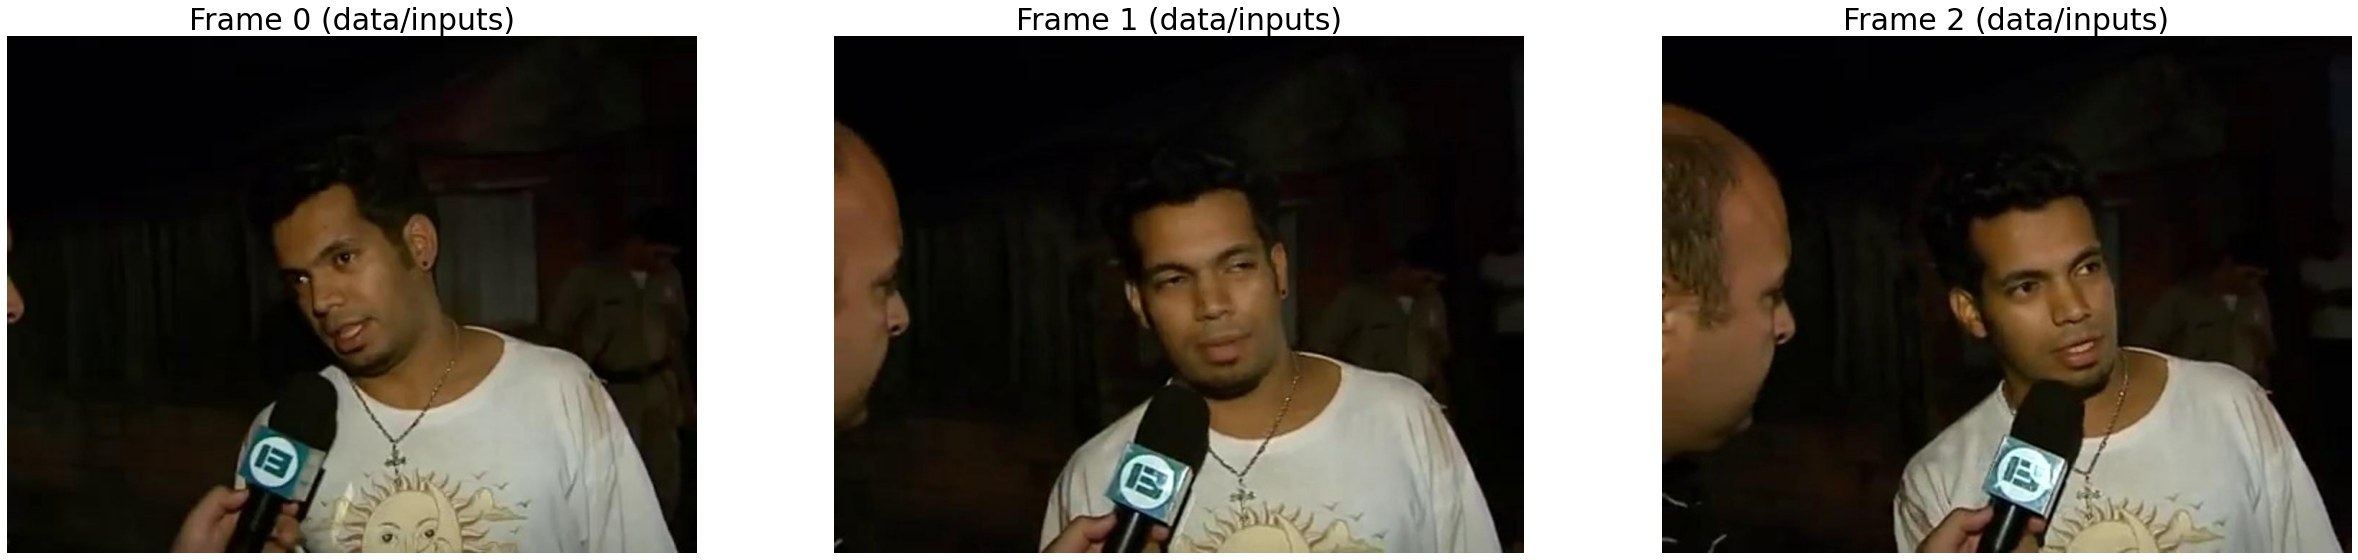

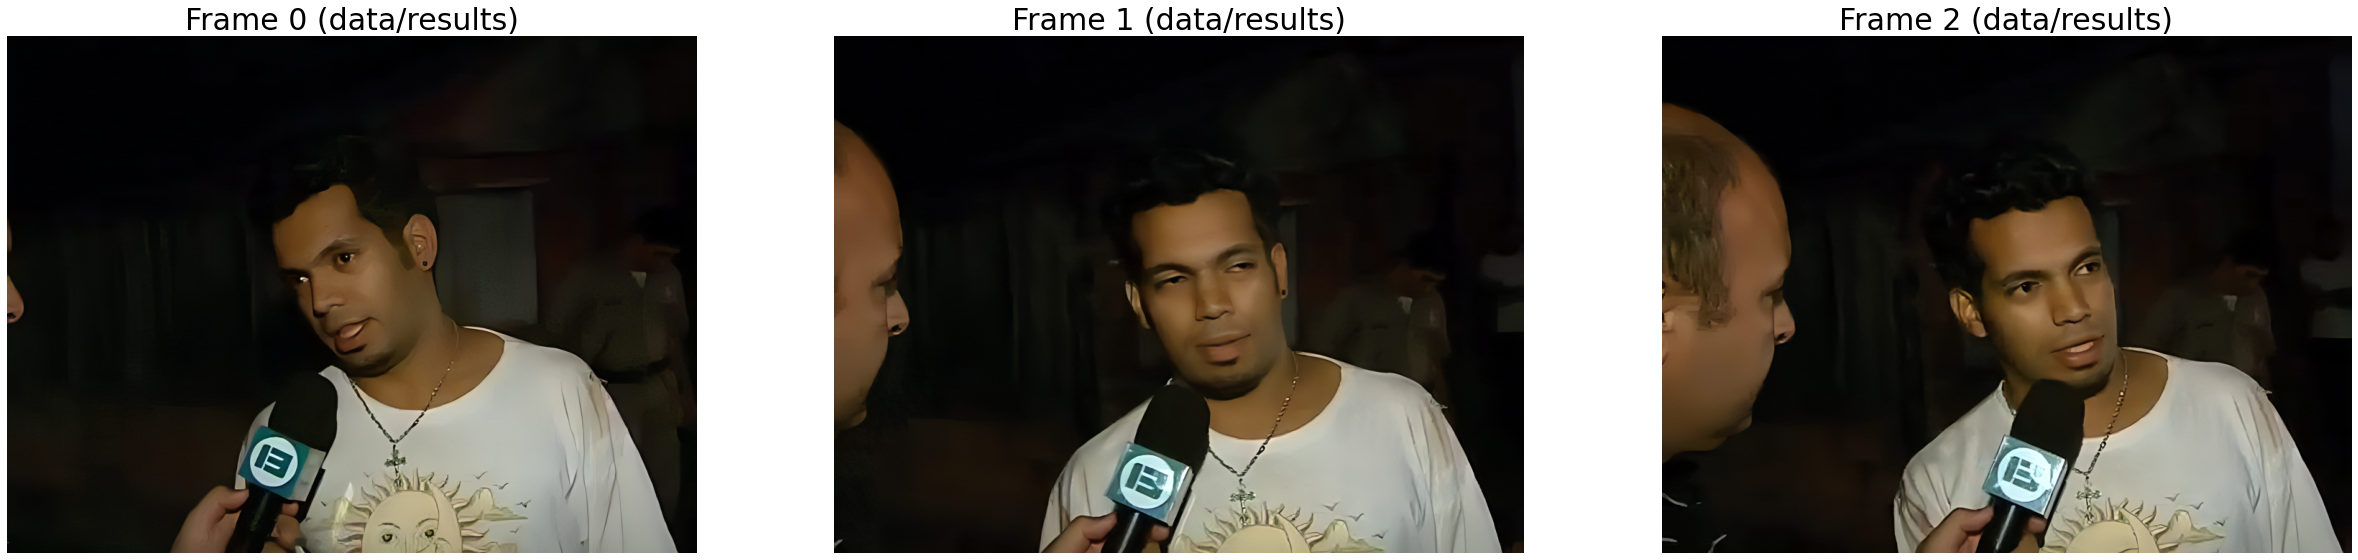

In [25]:
create_before_and_after_video(source_video_or_dir)

## References

```bibtex
@article{chan2021investigating,
  author = {Chan, Kelvin C.K. and Zhou, Shangchen and Xu, Xiangyu and Loy, Chen Change},
  title = {Investigating Tradeoffs in Real-World Video Super-Resolution},
  journal = {arXiv preprint arXiv:2111.12704},
  year = {2021}
}
```